In [1]:
## labraries for training

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_PLATFORM_NAME"] = "gpu"

import pennylane as qml
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp

import sys
sys.path.append('../..')

from src.train.mmdagg_probs import mmdagg_prob
from qcbm import QCBM


        

In [2]:
## for mi ansatz
def mutual_information_matrix(bits: jnp.ndarray) -> jnp.ndarray:
    """
    bits : (N, n)  0/1 ndarray
    return: (n, n)  float64 JAX array,  diag -> 0
    """
    N, n = bits.shape
    bits = bits.astype(jnp.int32)                  # 确保 0/1 -> 0/1 int

    # --- 1. single qubit edge probs P(q_k = 1) ---------------------------------
    pk1 = bits.mean(axis=0)                       # (n,)  float64
    pk0 = 1.0 - pk1                               # (n,)

    # --- 2. 2 qubits unite probs P(q_i = a, q_j = b) ------------------------
    #    P11(i,j) = mean( bits[:,i] & bits[:,j] )
    bT        = bits.T                            # (n, N)
    P11       = (bT[:, None, :] & bT[None, :, :]).mean(axis=-1)  # (n, n)
    
    P10 = pk1[:, None] - P11                      # (n, n)
    P01 = pk1[None, :] - P11
    P00 = 1.0 - (P11 + P10 + P01)

    # --- 3. mutal info I(i,j) = Σ_{a,b∈{0,1}} P_ab log( P_ab / (P_a·P_b) ) --
    eps  = 1e-12
    P_ab = jnp.stack([P00, P01, P10, P11], axis=0)       # (4, n, n)
    logt = jnp.log( jnp.clip(P_ab, eps) )
    pk0_col = pk0[:, None]          # (n,1)
    pk1_col = pk1[:, None]          # (n,1)
    logm = jnp.log( jnp.clip(
        jnp.stack([pk0_col*pk0,
                pk0_col*pk1,
                pk1_col*pk0, 
                pk1_col*pk1],
                axis=0), eps) )
    Iij  = jnp.sum(P_ab * (logt - logm), axis=0)         # (n, n)

    # --- 4. diag reset & return jnp.ndarray -------------------------------
    Iij = Iij.at[jnp.diag_indices(n)].set(0.0)
    return Iij


In [3]:
# ------------  init target probs & model & params ------------
from itertools import product
import sys
sys.path.append('../..')

import pandas as pd

df = pd.read_csv("../../data_2d/Qubits12/train.csv")
n_bits = 12
bit_cols = [f"q{i}" for i in range(n_bits)]
bitstrings = (
    df[bit_cols]
    .astype(str)
    .agg("".join, axis=1)
)
counts = bitstrings.value_counts().sort_index()
all_bits = ["".join(seq) for seq in product("01", repeat=n_bits)]
probs_full = pd.Series(0.0, index=all_bits, dtype=float)   # float64
probs_full.update(counts / counts.sum())                   # 归一化

gpu = jax.devices("gpu")[0]
target_probs = jax.device_put(jnp.asarray(probs_full.values, dtype=jnp.float64), gpu)

print("target_probs shape:", target_probs.shape,
      "dtype:", target_probs.dtype,
      "sum =", float(target_probs.sum()))

target_probs shape: (4096,) dtype: float64 sum = 1.0


In [4]:
# ------------ parameter counts ------------
# P = 222, n = 12, L = 10
def count_params1(n_bits: int, L: int) -> int:
    """
    return params requested for ansatz1
    """
    assert L % 2 == 0, "for ansatz1, L must be even number"
    return int((3 * L / 2 + 1) * n_bits - (L / 2))

# R = 3, C = 4, PL = 45, L = 5, P = 225 
def count_params2(R: int, C: int, L: int, periodic: bool = False) -> int:
    n = R * C
    per_layer = 2 * n + (R * (C - 1) + C * (R - 1))
    if periodic:
        per_layer += R + C
    return per_layer * L

# R = 3, C = 4, PL = 41, L = 5, P = 205
def count_params3(R: int, C: int, L: int, add_dt: bool = False) -> int:
    n = R * C
    per_layer = 2*n + R*(C-1) + (R-1)*C + (1 if add_dt else 0)
    return per_layer * L

# n = 12, L = 5, keep_edges = 20, extras = 6, P = 226
def count_params4(n: int, L: int, keep_edges: int, extras: int = 6) -> int:
    return 2*L*n + L*keep_edges + extras  

In [5]:
# ------------ ansatz factory ------------

from src.circuits.ansatz1 import hardware_efficient_ansatz
from src.circuits.ansatz2 import ising_structured_ansatz
from src.circuits.ansatz3 import eh2d_ansatz
from src.circuits.ansatz4 import mi_ansatz
## Control # of Params around 100


ansatz = ising_structured_ansatz
n_qubits= 12
mmd_fn = mmdagg_prob
R = 3
C = 4
keep_edges = 20
L1 = 10
L2 = 5

def ansatz_set(ansatz):
    if ansatz == hardware_efficient_ansatz:
        pc = count_params1(n_bits, L1)
        L = L1
        id = 1

    if ansatz == ising_structured_ansatz:
        pc = count_params2(R, C, L2, False)
        L = L2
        id = 2

    if ansatz == eh2d_ansatz:
        pc = count_params3(R, C, L2)
        L = L2
        id = 3

    if ansatz == mi_ansatz:
        pc = count_params4(n_qubits, L2, keep_edges)
        L = L2
        id = 4
        bit_np = df[bit_cols].values
        mi_mat = mutual_information_matrix(bit_np)
        triu_i, triu_j = jnp.triu_indices(n_qubits, k=1)
        mi_flat   = mi_mat[triu_i, triu_j]
        top_idx   = jnp.argsort(-mi_flat)[:keep_edges]
        mi_edges  = [(int(triu_i[k]), int(triu_j[k])) for k in top_idx]  # [(i,j),...]
        def ansatz_mi(params, wires, *, L=None, **kw):
            return mi_ansatz(
                params, wires,
                mi_edges = mi_edges,
                L = L,
                **kw
            )
        ansatz = ansatz_mi
    return ansatz, L, pc, id
ansatz, L, pc, id = ansatz_set(ansatz)

model = QCBM(ansatz, n_bits, L, mmd_fn, target_probs)
key = jax.random.PRNGKey(0)
params = jax.random.normal(key, shape=(pc,))


In [6]:
# # ------------ quick sanity check ------------
# key  = jax.random.PRNGKey(0)
# params = jax.random.normal(key, (pc,), dtype=jnp.float64)

# loss_val = model.loss(params)
# print("loss =", loss_val, "dtype:", loss_val.dtype, "device:", loss_val.device)

# grads = jax.grad(model.loss)(params)
# print("grads shape", grads.shape, "dtype:", grads.dtype, "device:", grads.device)


In [7]:
# ------------ training set up ------------
import optax
import catalyst

# opt = optax.adam(1e-2)

lr_sched = optax.exponential_decay(  # 从 1e‑2 → 每 200 步 × 0.9
    init_value=1e-2, transition_steps=200, decay_rate=0.9, staircase=True
)
opt = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(lr_sched, b2=0.999)
)


def update_step(i, params, opt_state, loss_log):
    loss_val, grads = catalyst.value_and_grad(model.loss)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    loss_log = loss_log.at[i].set(loss_val)
    grad_norm = optax.global_norm(grads)
    catalyst.debug.print("Step {i}: loss = {loss}, grad_norm = {g}", i=i, loss=loss_val, g=grad_norm)

    return (params, opt_state, loss_log)

@qml.qjit     
def optimization(params, n_steps: int = 1000):
    opt_state = opt.init(params)
    loss_log  = jnp.zeros(n_steps, dtype=params.dtype)
    params, opt_state, loss_log = qml.for_loop(
        0, n_steps, 1
    )(update_step)(params, opt_state, loss_log)
    return params, loss_log

In [8]:
# circuit = model.circuit

# @jax.jit
# def loss(params):
#     qcbm_probs = circuit(params)

#     def kl_div(p, q, eps=1e-10):
#         p = jnp.clip(p, eps, 1.0)
#         q = jnp.clip(q, eps, 1.0)
#         p = p / p.sum()
#         q = q / q.sum()
#         return jnp.sum(p * jnp.log(p / q))

#     loss_mmd = mmd_fn(
#         target_probs,
#         qcbm_probs,
#         kernel="laplace_gaussian",
#         number_bandwidths=10,
#         weights_type="uniform",
#         build_details=False,  
#         dtype=jnp.float64,
#     )
#     return loss_mmd * 0.7 + kl_div(target_probs, qcbm_probs) * 0.3



In [ ]:
# import jax
# import jax.numpy as jnp
# from jax import jit, value_and_grad
# import optax

# # === 超参数 ===
# n_steps = 1000
# batch_size = 64
# noise_std = 0.01

# # === 优化器设定 ===
# lr_sched = optax.exponential_decay(
#     init_value=1e-2, transition_steps=200, decay_rate=0.9, staircase=True
# )
# optimizer = optax.chain(
#     optax.clip_by_global_norm(1.0),
#     optax.adam(lr_sched, b2=0.999)
# )

# # === batch loss 函数（每一步用不同 key）===
# def batched_loss_fn(params, step):
#     key = jax.random.PRNGKey(step)
#     noise = noise_std * jax.random.normal(key, (batch_size, params.shape[0]))
#     params_batch = params + noise

#     losses = jax.vmap(lambda p: loss(p))(params_batch)
#     return jnp.mean(losses)

# # === 包装成 JIT + grad ===
# @jit
# def grad_fn_with_step(params, step):
#     return value_and_grad(lambda p: batched_loss_fn(p, step))(params)

# # === 单步训练 ===
# @jit
# def update_step(i, params, opt_state, loss_log):
#     loss, grads = grad_fn_with_step(params, i)
#     updates, opt_state = optimizer.update(grads, opt_state)
#     params = optax.apply_updates(params, updates)
#     loss_log = loss_log.at[i].set(loss)
#     return params, opt_state, loss_log

# # === 主训练循环 ===
# def make_optimization(n_steps):
#     @jit
#     def optimization(params):
#         opt_state = optimizer.init(params)
#         loss_log = jnp.zeros(n_steps, dtype=params.dtype)

#         def body(i, val):
#             params, opt_state, loss_log = val
#             return update_step(i, params, opt_state, loss_log)

#         return jax.lax.fori_loop(0, n_steps, body, (params, opt_state, loss_log))

#     return optimization

# # === 创建并执行训练 ===
# optimization = make_optimization(n_steps)


: 

In [ ]:
# ------------ training steps ------------

trained_params, loss_hist = optimization(params)



Step 0: loss = 2.1227703898063854, grad_norm = 1.7811951913498185
Step 1: loss = 1.979033796085783, grad_norm = 1.5440016006809383
Step 2: loss = 1.8565502380918972, grad_norm = 1.3609381344967806
Step 3: loss = 1.7506885748103371, grad_norm = 1.2145111212377147
Step 4: loss = 1.6582696498328624, grad_norm = 1.0939795831292471
Step 5: loss = 1.5769218954175648, grad_norm = 0.993272973357924
Step 6: loss = 1.5045233119027128, grad_norm = 0.9090857998676676
Step 7: loss = 1.4395832217923097, grad_norm = 0.8360875420097215
Step 8: loss = 1.3811703869025727, grad_norm = 0.7684622240196167
Step 9: loss = 1.3287643109448601, grad_norm = 0.7058891850439615
Step 10: loss = 1.2817679117514598, grad_norm = 0.6488233305261631
Step 11: loss = 1.239480044847387, grad_norm = 0.5970893753792966
Step 12: loss = 1.20135421694948, grad_norm = 0.5492544551016841
Step 13: loss = 1.1668802716202835, grad_norm = 0.5067863853323277
Step 14: loss = 1.1356970089499097, grad_norm = 0.46470739421314045
Step 15: 

In [ ]:
jax.block_until_ready(trained_params)      # wait until training ends

# ───── save ─────
import numpy as np
from pathlib import Path
run_id = f"result{id}"


out_dir = Path("../../data/results/Qubits12")/run_id
out_dir.mkdir(parents=True, exist_ok=True)

np.save(out_dir / f"params.npy",  jax.device_get(trained_params))
np.save(out_dir / f"loss.npy", jax.device_get(loss_hist))

print(f"model params have saved to: {out_dir / 'params.npy'}")
print(f"Loss record has saved to: {out_dir / 'loss.npy'}")

NameError: name 'jax' is not defined

In [ ]:
# ───── 2. load the model ─────
import scipy
from pathlib import Path
import jax
import jax.numpy as jnp
import numpy as np
out_dir = Path(f"../../data/results/result{id}")
loaded_params = jnp.asarray(np.load(out_dir/"params.npy"), dtype=jnp.float64)

model = QCBM(ansatz, n_bits, L, mmdagg_prob, target_probs)  # 跟训练时相同
loss_loaded = loss(loaded_params).block_until_ready()
print("Loss after reload:", float(loss_loaded))

probs_trained = model.circuit(loaded_params).block_until_ready()
kl   = scipy.stats.entropy(target_probs, probs_trained)
l1   = jnp.mean(jnp.abs(target_probs - probs_trained))
gpu = jax.devices("gpu")[0]
mmd, _ = mmdagg_prob(jax.device_put(target_probs, gpu), 
                     jax.device_put(probs_trained, gpu),
                     kernel="laplace_gaussian", number_bandwidths=10)
mask = target_probs > 0          # only check the non-zero part
kl_nonzero = scipy.stats.entropy(
    target_probs[mask],
    probs_trained[mask] / probs_trained[mask].sum()
)



print(f"KL   : {kl:.4e}")
print("KL (target>0 only):", kl_nonzero)
print(f"L1   : {l1:.4e}")
print(f"MMD  : {mmd:.4e}")

Loss after reload: 0.017519396353931176
KL   : 5.8318e-02
KL (target>0 only): 0.023321320713117023
L1   : 4.7178e-04
MMD  : 3.4205e-05


First 5 losses: [1.1846474  1.13500184 1.08817893 1.04396617 1.00213912]
Final   loss : 0.0175215416003253


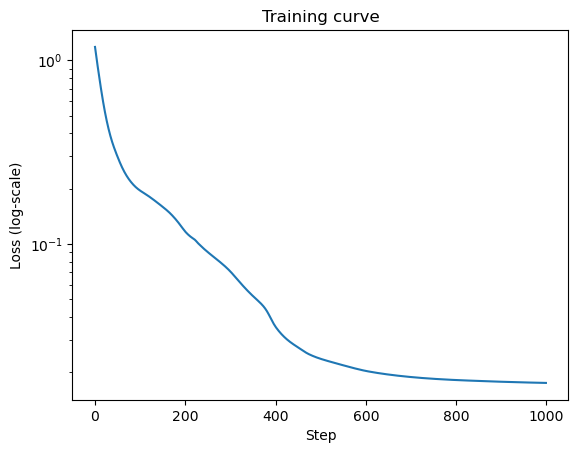

In [ ]:
import matplotlib.pyplot as plt

params_loaded   = loaded_params
loss_hist_loaded = np.load(f"{out_dir}/loss.npy")

print("First 5 losses:", loss_hist_loaded[:5])
print("Final   loss :", loss_hist_loaded[-1])

plt.semilogy(loss_hist_loaded)
plt.xlabel("Step")
plt.ylabel("Loss (log‑scale)")
plt.title("Training curve")
plt.show()


In [ ]:
DATA_DIR   = "../../data"
def csv_to_probs(path: str, n_bits=8, dtype=jnp.float64):
    df = pd.read_csv(path, dtype=str)
    bitstrings = df["bitstring"].str.strip().str.zfill(n_bits)
    counts = bitstrings.value_counts().sort_index()
    all_bits = ["".join(seq) for seq in product("01", repeat=n_bits)]
    probs = pd.Series(0.0, index=all_bits, dtype=float)
    probs.update(counts / counts.sum())
    return jnp.asarray(probs.values, dtype=dtype)

def kl_div(p, q, eps=1e-10):
    p = jnp.clip(p, eps, 1.0)
    q = jnp.clip(q, eps, 1.0)
    p = p / p.sum();  q = q / q.sum()
    return jnp.sum(p * jnp.log(p / q))

# ---------- load trained params ----------
params_loaded = params_loaded

# ---------- build QCBM ----------
model = QCBM(
    ansatz       = ansatz,
    n_qubits     = 8,
    L            = 4,
    mmd_fn       = mmdagg_prob,
    target_probs = jnp.zeros(256),   # 占位即可
    dtype        = jnp.float64,
)

# ---------- K1, L1, MMD ----------
@jax.jit
def three_metrics(target_probs, params):
    probs = model.circuit(params)
    kl    = kl_div(target_probs, probs)
    l1    = jnp.mean(jnp.abs(target_probs - probs))
    mmd   = mmdagg_prob(
        target_probs, probs,
        kernel="laplace_gaussian", number_bandwidths=10,
        build_details=False, dtype=jnp.float64
    )
    return kl, l1, mmd

# ---------- calculate & print ----------
splits = {
    "TEST"  : csv_to_probs("../../data_2d/test.csv"),
    "UNSEEN": csv_to_probs("../../data_2d/unseen.csv"),
}

for name, tgt in splits.items():
    kl, l1, mmd = three_metrics(tgt, params_loaded)
    kl, l1, mmd = map(lambda x: float(x.block_until_ready()), (kl, l1, mmd))
    print(f"{name:6s}:  KL = {kl:.4e}   L1 = {l1:.4e}   MMD = {mmd:.4e}")

TEST  :  KL = 1.4397e+00   L1 = 5.1414e-03   MMD = 2.4332e-02
UNSEEN:  KL = 1.5082e+00   L1 = 5.3655e-03   MMD = 2.3912e-02
